In [20]:
"""
@utor : Alexandre
Δate : 2024-03-28
"""

'\n@utor : Alexandre\nΔate : 2024-03-28\n'

# **Trying to make something fun with a new dataset**

## Loading and preparation of the dataset

In [21]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import load_iris
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

In [22]:
dataset = load_iris()

In [23]:
print(dataset["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [24]:
columns_name = dataset["feature_names"]
target_name = dataset["target_names"]
columns = [columns_name[i].replace(" ","_").split("_(")[0] for i in range(len(columns_name))]

In [25]:
Y = pd.DataFrame(dataset["target"], columns=["target"])
x = pd.DataFrame(dataset["data"], columns=columns)

In [26]:
sepal_area = pd.DataFrame((x["sepal_length"] * x["sepal_width"]) / 2, columns=["sepal_area"])
petal_area = pd.DataFrame((x["petal_length"] * x["petal_width"]) / 2, columns=["petal_area"])

In [27]:
X = pd.concat(
    [
        x,
        sepal_area,
        petal_area
    ], axis=1
)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(
    X.to_numpy(),
    Y.to_numpy()[:,0],
    test_size=.2
    )

In [30]:
scaler = StandardScaler().fit(X_train_)
X_train = scaler.transform(X_train_)
X_test = scaler.transform(X_test_)
Y_train = Y_train_
Y_test = Y_test_

## Model and training preparation

In [31]:
from torch.utils.data import TensorDataset, DataLoader

In [32]:
# model de classification
class my_classifier(torch.nn.Module):
    def __init__(self, N_feature, N_classe):
        super(my_classifier, self).__init__()
         
        self.linear = torch.nn.Linear(N_feature, N_classe)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        
        x_in = self.linear(x)
        x_out = self.logsoftmax(x_in)

        return x_out

In [33]:
# select the device support
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda" : torch.cuda.empty_cache()
print(f"{device = } !")

device = 'cuda' !


In [34]:
# training fonction for the model
def train_model(
        num_epochs=300,
        criterion="bce",
        optimizer="adam",
        batch_size=2**4,
        lr=1e-3, # optmizer
        betas=(0.9,0.999), # adam
        alpha=0.99, # rmsprop
        eps=1e-08, # rmsprop / adam
        weight_decay=0, # rmsprop / adam
        momentum=0, # rmsprop

        
        N_feature=X_train.shape[-1],
        N_classe=np.unique(Y_train).shape[0],

        X_train=X_train,
        Y_train=Y_train,
        X_test=X_test,
        Y_test=Y_test,
        device=device,

        disable_tqdm=False,
        verbose=False
):
    
    # Initialisation
    model = my_classifier(
        N_feature=N_feature,
        N_classe=N_classe
        ).to(device)
    
    # select the loss function
    if criterion == "bce":
        criterion = torch.nn.BCELoss(reduction="mean") 
    if criterion == "nll":
        criterion = torch.nn.NLLLoss(reduction="mean")

    # gradient descent optimizer
    if optimizer == "adam":
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay
            )
    if optimizer == "rmsprop":
        optimizer = torch.optim.RMSprop(
            model.parameters(), 
            lr=lr,
            alpha=alpha,
            eps=eps,
            weight_decay=weight_decay,
            momentum=momentum
            )

    # data preparation
    X_train = torch.Tensor(X_train).to(device)
    Y_train = torch.Tensor(Y_train).to(device)
    X_test = torch.Tensor(X_test).to(device)
    Y_test = torch.Tensor(Y_test).to(device)

    loader = DataLoader(
        TensorDataset(X_train,Y_train), 
        batch_size=batch_size, 
        shuffle=True
    )

    # result vector
    results_loss_train = torch.zeros((num_epochs))
    results_loss_test = torch.zeros((num_epochs))
    results_accuracy = torch.zeros((num_epochs))

    for epoch in tqdm(range(num_epochs), disable=disable_tqdm):
        
        loss_ = []

        for X_, Y_ in loader:

            X_, Y_ = X_.to(device), Y_.to(device)
            model.train()
            output = model(X_)
            
            loss = criterion(output, Y_.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_.append(loss.item())

        results_loss_train[epoch] = np.sum(loss_)

        if verbose == True and (epoch % (num_epochs // 16) == 0):

            print(f"Iteration: {epoch} / {num_epochs} - Loss: {loss.item():.5e}")

        with torch.no_grad() :

            Y_pred = model(X_test)
            loss = criterion(Y_pred, Y_test.long())

            results_loss_test[epoch] = loss.item()
            results_accuracy[epoch] = balanced_accuracy_score(
                y_true=Y_test.cpu().detach().round(),
                y_pred=torch.argmax(Y_pred.cpu().detach(), axis=-1).round()
            )
    
    return results_loss_train, results_loss_test, results_accuracy, model

## Training

In [35]:
results_loss_train, results_loss_test, results_accuracy, model = train_model(
    X_train=X_train,
    X_test=X_test,
    Y_train=Y_train,
    Y_test=Y_test,
    criterion="nll",
    optimizer="rmsprop",
    batch_size=2**3,
    num_epochs=500
)

100%|██████████| 500/500 [00:09<00:00, 52.71it/s]


In [36]:
import matplotlib.pyplot as plt

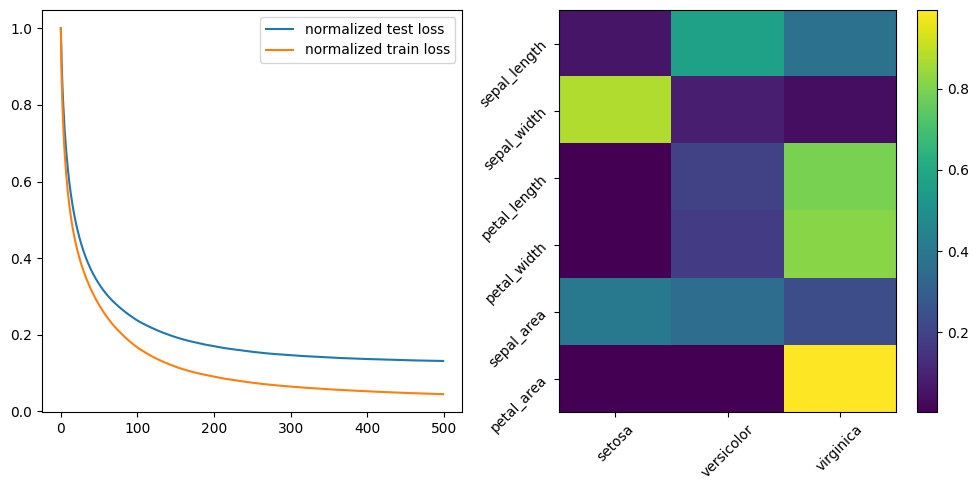

In [37]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10,5)
)

ax[0].plot(
    range(500),
    results_loss_test/results_loss_test.max(),
    label="normalized test loss"
)

ax[0].plot(
    range(500),
    results_loss_train/results_loss_train.max(),
    label="normalized train loss"
)

g = ax[1].imshow(
    torch.softmax(model.linear.weight.cpu(), axis=0).detach().numpy().T,
    aspect="auto"
)
ax[1].set_yticks(range(X.keys().shape[0]), X.keys(), rotation=45)
ax[1].set_xticks(range(np.unique(Y).shape[0]), target_name, rotation=45)
fig.colorbar(g, ax=ax[1])

ax[0].legend()
plt.tight_layout()
plt.show()

In [38]:
print(f"balanced accuracy = {results_accuracy[-5:].mean().item()*100} %")

balanced accuracy = 93.63635778427124 %
